Import needed libraries and the dataset csv

(19980, 21)

Clean up the dataset

In [335]:
import pandas as pd
import numpy as np
from pathlib import Path
import re

# Build path to file
# Selects current working directory
cwd = Path.cwd()
csv_path = 'data/dataframe.csv'
csv_cleaned_path = 'output/dataframe_cleaned.csv'
src_path = (cwd / csv_path).resolve()
out_path = (cwd / csv_cleaned_path).resolve()

# Read the csv
csv = pd.read_csv(src_path, index_col=0)
csv.shape

# Removing unneeded data
# dropping empty rows
csv = csv.dropna(how='all')
# dropping duplicates (if any)
csv = csv.drop_duplicates()
# Dropping house and appartment groups since they have no data
csv = csv.drop(csv[(csv['property_type'] == 'HOUSE_GROUP') | (csv['property_type'] == 'APARTMENT_GROUP')].index)
# Drop rows without a price property
csv = csv.drop(csv[pd.isna(csv['price']) == True].index)
# Drop rows with 0 rooms
csv = csv.drop(csv[csv['number_rooms'] == 0].index)
# Drop rows without a living area property
csv = csv.drop(csv[pd.isna(csv['living_area']) == True].index)
# Assuming that a NaN value or 0 means no kitchen installed, replacing the strings with integers
# 0 = NOT_INSTALLED, 0.5 = SEMI_EQUIPPED, 1 = INSTALLED, 2 = HYPER_EQUIPPED
csv['kitchen'] = csv['kitchen'].fillna('NOT_INSTALLED')
csv['kitchen'] = csv['kitchen'].replace('0', 'NOT_INSTALLED')
csv['kitchen'] = csv['kitchen'].replace(0, 'NOT_INSTALLED')
"""csv['kitchen'] = csv['kitchen'].replace('USA_UNINSTALLED', 0)
csv['kitchen'] = csv['kitchen'].replace('SEMI_EQUIPPED', 0.5)
csv['kitchen'] = csv['kitchen'].replace('USA_SEMI_EQUIPPED', 0.5)
csv['kitchen'] = csv['kitchen'].replace('INSTALLED', 1)
csv['kitchen'] = csv['kitchen'].replace('USA_INSTALLED', 1)
csv['kitchen'] = csv['kitchen'].replace('HYPER_EQUIPPED', 2)
csv['kitchen'] = csv['kitchen'].replace('USA_HYPER_EQUIPPED', 2)"""
# Filling empty values and changing true/false to 1/0
csv['furnished'] = csv['furnished'].fillna(0)
csv['furnished'] = csv['furnished'].replace(False, 0)
csv['furnished'] = csv['furnished'].replace(True, 1)
# Assuming that a NaN value,0 or -1 means no fireplace installed
csv['fireplace'] = csv['fireplace'].fillna(0)
csv['fireplace'] = csv['fireplace'].replace(-1, 0)
# Filling empty values and changing true/false to 1/0
csv['terrace'] = csv['terrace'].fillna(0)
csv['terrace'] = csv['terrace'].replace(False, 0)
csv['terrace'] = csv['terrace'].replace(True, 1)
# Assuming the surface area = living area in case of apartments
to_replace = csv[((csv['surface_land'] == 'UNKNOWN')|(pd.isna(csv['surface_land']) == True)) & (csv['property_type'] == 'APARTMENT')]
to_replace = to_replace.reset_index()
# Looping through rows to replace the values
for index, row in to_replace.iterrows():
    csv.loc[row['index'], 'surface_land'] = row['living_area']
# Dropping rows with no surface area 
csv = csv.drop(csv[(csv['surface_land'] == 'UNKNOWN') | (pd.isna(csv['surface_land']) == True) | (csv['surface_land'] == 0)].index)
# Dropping rows with no facade info
csv = csv.drop(csv[(csv['number_facades'] == 'UNKNOWN') | (pd.isna(csv['number_facades']) == True)].index)
# Filling empty values and changing true/false to 1/0
csv['swimming_pool'] = csv['swimming_pool'].fillna(0)
csv['swimming_pool'] = csv['swimming_pool'].replace(False, 0)
csv['swimming_pool'] = csv['swimming_pool'].replace(True, 1)
csv = csv.drop(csv[(csv['building_state'] == 'UNKNOWN') | (pd.isna(csv['building_state']) == True)].index)

# If terrace = 1 but no terrace_area present, drop the row
csv = csv.drop(csv[(csv['terrace'] == 1) & (pd.isna(csv['terrace_area']) == True)].index)
# Filling empty values and changing true/false to 1/0
csv['terrace_area'] = csv['terrace_area'].fillna(0)
# If garden = 1 but no garden_area present, drop the row
csv = csv.drop(csv[(csv['garden'] == 1) & (pd.isna(csv['garden_area']) == True)].index)
# No garden, filling empty values
csv['garden'] = csv['garden'].fillna(0)
csv['garden'] = csv['garden'].replace(False, 0)
csv['garden'] = csv['garden'].replace(True, 1)
csv['garden_area'] = csv['garden_area'].fillna(0)

# Change strings to floats in certain columns
csv = csv.drop(csv[(csv['surface_land'] == 0)].index)
csv['surface_land']=csv['surface_land'].astype("float")
csv['number_facades']=csv['number_facades'].astype("float")
csv = csv.drop(csv[csv['zip_code'] == 'UNKNOWN'].index)
csv = csv.drop(csv[pd.isna(csv['region']) == True].index)
csv = csv.drop(csv[pd.isna(csv['province']) == True].index)
csv['zip_code']=csv['zip_code'].astype("str")
csv['ppm'] = csv['price']/csv['surface_land']

patternDel = "\b[0-9]\{4\}\b"
filter = csv['zip_code'].str.contains(patternDel)
csv = csv[~filter]

# Saves cleaned up csv to 'data/dataframe_cleaned.csv'
csv.to_csv(out_path)
csv.shape


(6890, 22)

In [382]:
def convert(n):
    return str(int(int(n)/100))
csv["digit"]=csv["zip_code"].agg(convert)

In [354]:
# Removing outliers as a test
cols = ['price', 'number_rooms', 'living_area',
       'furnished', 'fireplace', 'terrace', 'terrace_area', 'garden',
       'garden_area', 'surface_land', 'number_facades', 'swimming_pool'] # one or more

Q1 = csv[cols].quantile(0.25)
Q3 = csv[cols].quantile(0.75)
IQR = Q3 - Q1

csv = csv[~((csv[cols] < (Q1 - 1.5 * IQR)) |(csv[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [325]:
csv['zip_code'].value_counts().value_counts()

count
1     126
2      71
3      33
5      20
4      19
6      13
7      10
15      5
11      5
14      5
18      3
10      2
23      2
8       2
9       2
13      2
19      2
12      1
20      1
16      1
45      1
21      1
22      1
31      1
37      1
40      1
52      1
Name: count, dtype: int64

In [503]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder


x = csv[['number_rooms', 'living_area',
       'terrace', 'terrace_area', 'garden',
       'garden_area', 'surface_land', 'number_facades',
       'property_type', 'building_state', 'kitchen', 'digit']]

x = pd.get_dummies(data=x, drop_first=True)
X = x.to_numpy()
y = csv['price'].to_numpy()

print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

regressor = LinearRegression().fit(X_train, y_train)

score_train = regressor.score(X_train, y_train)
score_test = regressor.score(X_test, y_test)

# Get the root mean squared error
y_pred = regressor.predict(X_test)
#rmse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
rmse= np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))

u = ((y_test - y_pred)**2).sum()
v = ((y_test - y.mean())**2).sum()
coef_determination = 1 - u/v

print(f"score train:{score_train}")
print(f"score test:{score_test}")
print(f"rmse:{rmse}")
print(f"coef_determination:{coef_determination}")

(4774, 98)
score train:0.7106395662926464
score test:0.7296969088324883
rmse:90943.46048140155
coef_determination:0.7297027943879353


In [504]:
# TODO: zijn er variabelen met extreme coefficienten?
# TODO: welke zijn de hoogste predictions, hoe zien de X eruit daarvoor?
# TODO: normaliseer numerical variabelen tussen 0-1 (StandardScaler())
# TODO: zipcode minder granulair?
dict_coef = {x.columns[i]: regressor.coef_[i] for i in range(len(x.columns))}
dict_coef

{'number_rooms': 76922.92390160236,
 'living_area': 377092.3761515749,
 'terrace': 5834.785755696183,
 'terrace_area': 31193.242169320758,
 'garden': 9742.589642986088,
 'garden_area': -5903.74694984392,
 'surface_land': 109757.3605649188,
 'number_facades': 41647.978201766025,
 'property_type_HOUSE': 14055.532066427797,
 'building_state_GOOD': -50601.22627741234,
 'building_state_JUST_RENOVATED': -23630.447135264258,
 'building_state_TO_BE_DONE_UP': -77888.01274414023,
 'building_state_TO_RENOVATE': -112504.51404308999,
 'building_state_TO_RESTORE': -102125.14970276051,
 'kitchen_INSTALLED': -20737.430564810114,
 'kitchen_NOT_INSTALLED': -26333.772745557246,
 'kitchen_SEMI_EQUIPPED': -33023.683210271585,
 'kitchen_USA_HYPER_EQUIPPED': 20101.512381695327,
 'kitchen_USA_INSTALLED': -41734.61688273767,
 'kitchen_USA_SEMI_EQUIPPED': 3890.0320405411185,
 'digit_11': 71110.67379248986,
 'digit_12': 80651.4068886189,
 'digit_13': -60856.6226004801,
 'digit_14': -106865.14856902589,
 'digit_1

In [231]:
max(y_test)

1850000.0

In [232]:
np.quantile(y_pred, q=0.90)

734689.0855482789

array([[<Axes: title={'center': '0'}>]], dtype=object)

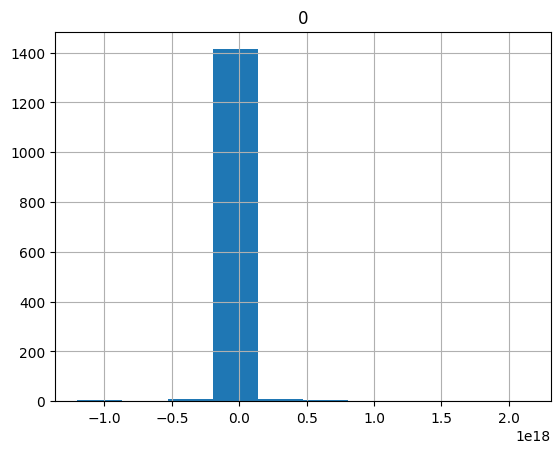

In [233]:
pd.DataFrame(y_pred).hist(bins=10)


In [505]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=5000)
clf.fit(X_train, y_train)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), max_iter=5000,
              random_state=1, solver='lbfgs')

In [508]:
clf.score(X_train, y_train)

0.05698324022346369